In [ ]:
!pip install scikeras

import os
import sys
import regex
import datetime
import math

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics

import pandas as pd
from numpy import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
def load_data():
    data = pd.read_csv(
        "/content/sample_data/powerconsumption.csv",
        index_col="Datetime",
        parse_dates=True,
    )
    return data

In [ ]:
def preprocess_data(data):
    data = data.ffill()
    data_resampled = data.resample("D").mean()
    data_resampled.index = pd.to_datetime(data_resampled.index)
    data_resampled.sort_index(ascending=True, inplace=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_resampled)

    return scaled_data, scaler

In [ ]:
def create_lstm_model(input_shape, units=50):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
def prepare_lstm_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
def find_best_params(train_X, train_y, epochs_range, batch_size_range, lstm_units_range):
    model = KerasRegressor(build_fn=create_lstm_model)

    param_grid = {
        'epochs': epochs_range,
        'batch_size': batch_size_range,
        'estimator__units': lstm_units_range
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_result = grid_search.fit(train_X, train_y)

    print("Best Parameters:")
    print(grid_result.best_params_)

    return grid_result.best_estimator_

In [ ]:
def lstm_forecasting(train_data, test_data, n_steps):
    train_X, train_y = prepare_lstm_data(train_data, n_steps)
    test_X, test_y = prepare_lstm_data(test_data, n_steps)

    n_features = train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

    model = create_lstm_model((train_X.shape[1], train_X.shape[2]), 100)
    model.fit(train_X, train_y, epochs=100, batch_size=64, verbose=1)

    y_pred = model.predict(test_X)

    mape = mean_absolute_percentage_error(test_y, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(test_y, y_pred))
    mae = mean_absolute_error(test_y, y_pred)
    r2 = r2_score(test_y, y_pred)

    result = [
        {"title": "Predicted Values", "value": y_pred},
        {"title": "Actual Values", "value": test_y},
        {"title": "MAPE", "value": mape},
        {"title": "RMSE", "value": rmse},
        {"title": "MAE", "value": mae},
        {"title": "R2", "value": r2}
    ]

    return result

In [ ]:
def impute_missing_values(data):
    imputer = SimpleImputer(strategy="mean")
    data_filled = imputer.fit_transform(data)
    data_filled = pd.DataFrame(data_filled, columns=data.columns, index=data.index)
    return data_filled


def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(data)
    data_normalized = pd.DataFrame(data_normalized, columns=data.columns, index=data.index)
    return data_normalized, scaler


def prepare_data_lstm(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:(i + sequence_length)].values)
        y.append(data.iloc[i + sequence_length].values)
    return np.array(X), np.array(y)


In [ ]:
data = load_data()

In [ ]:
data

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259


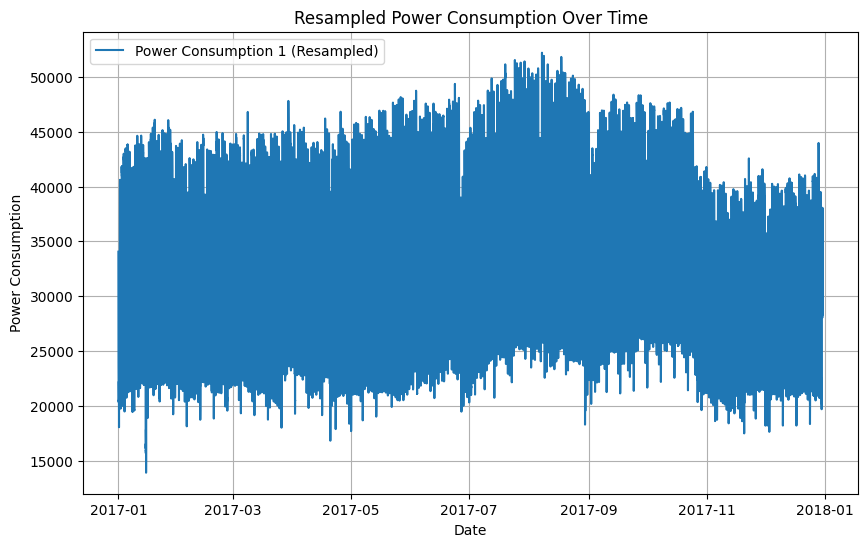

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['PowerConsumption_Zone1'], label='Power Consumption 1 (Resampled)')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.title('Resampled Power Consumption Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data_imputed = impute_missing_values(data)
data_normalized, scaler = normalize_data(data_imputed)

sequence_length = 10
X, y = prepare_data_lstm(data_normalized, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(y_train.shape[1]))

model.compile(loss="mean_squared_error", optimizer="adam")

model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

predictions = model.predict(X_test)

Epoch 1/100
737/737 [==============================] - 15s 16ms/step - loss: 0.0057
Epoch 2/100
737/737 [==============================] - 15s 20ms/step - loss: 0.0012
Epoch 3/100
737/737 [==============================] - 12s 17ms/step - loss: 8.2669e-04
Epoch 4/100
737/737 [==============================] - 12s 16ms/step - loss: 6.8432e-04
Epoch 5/100
737/737 [==============================] - 12s 16ms/step - loss: 6.1170e-04
Epoch 6/100
737/737 [==============================] - 12s 16ms/step - loss: 5.7995e-04
Epoch 7/100
737/737 [==============================] - 12s 16ms/step - loss: 5.6106e-04
Epoch 8/100
737/737 [==============================] - 12s 16ms/step - loss: 5.4283e-04
Epoch 9/100
737/737 [==============================] - 12s 16ms/step - loss: 5.3107e-04
Epoch 10/100
737/737 [==============================] - 11s 15ms/step - loss: 5.2158e-04
Epoch 11/100
737/737 [==============================] - 15s 21ms/step - loss: 5.1221e-04
Epoch 12/100
737/737 [================

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

def calculate_metrics(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return mape, rmse, mae

mape, rmse, mae = calculate_metrics(y_test_inverse, predictions_inverse)
r2 = r2_score(y_test_inverse, predictions_inverse)

print("R-squared (R2) score:", r2)
print("MAPE:", mape)
print("RMSE:", rmse)
print("MAE:", mae)

R-squared (R2) score: 0.97729510782923
MAPE: 1147.9171545580384
RMSE: 214.9959266048812
MAE: 99.5288013432545


In [ ]:
mse = mean_squared_error(y_test_inverse, predictions_inverse)
mse

46223.248456691465

In [ ]:
support vector machine
regression
decision Tree


SyntaxError: invalid syntax (<ipython-input-15-e983e42f6854>, line 1)